# 误警率 绘图


正态分布拟合外推法
拟合的正态分布参数: μ (均值) = 0.31, σ (标准差) = 0.05
根据拟合分布，得分>=0.46的概率(FAP)为: 1.10e-03
对应的统计显著性为: 3.06 σ (sigma)

--- 使用 Chi-Squared 分布进行拟合与评估 ---
[Chi-Squared分布] FAP: 6.00e-03,  显著性: 2.51 σ
  拟合参数: df(自由度)=66.15, loc=0.00, scale=0.00


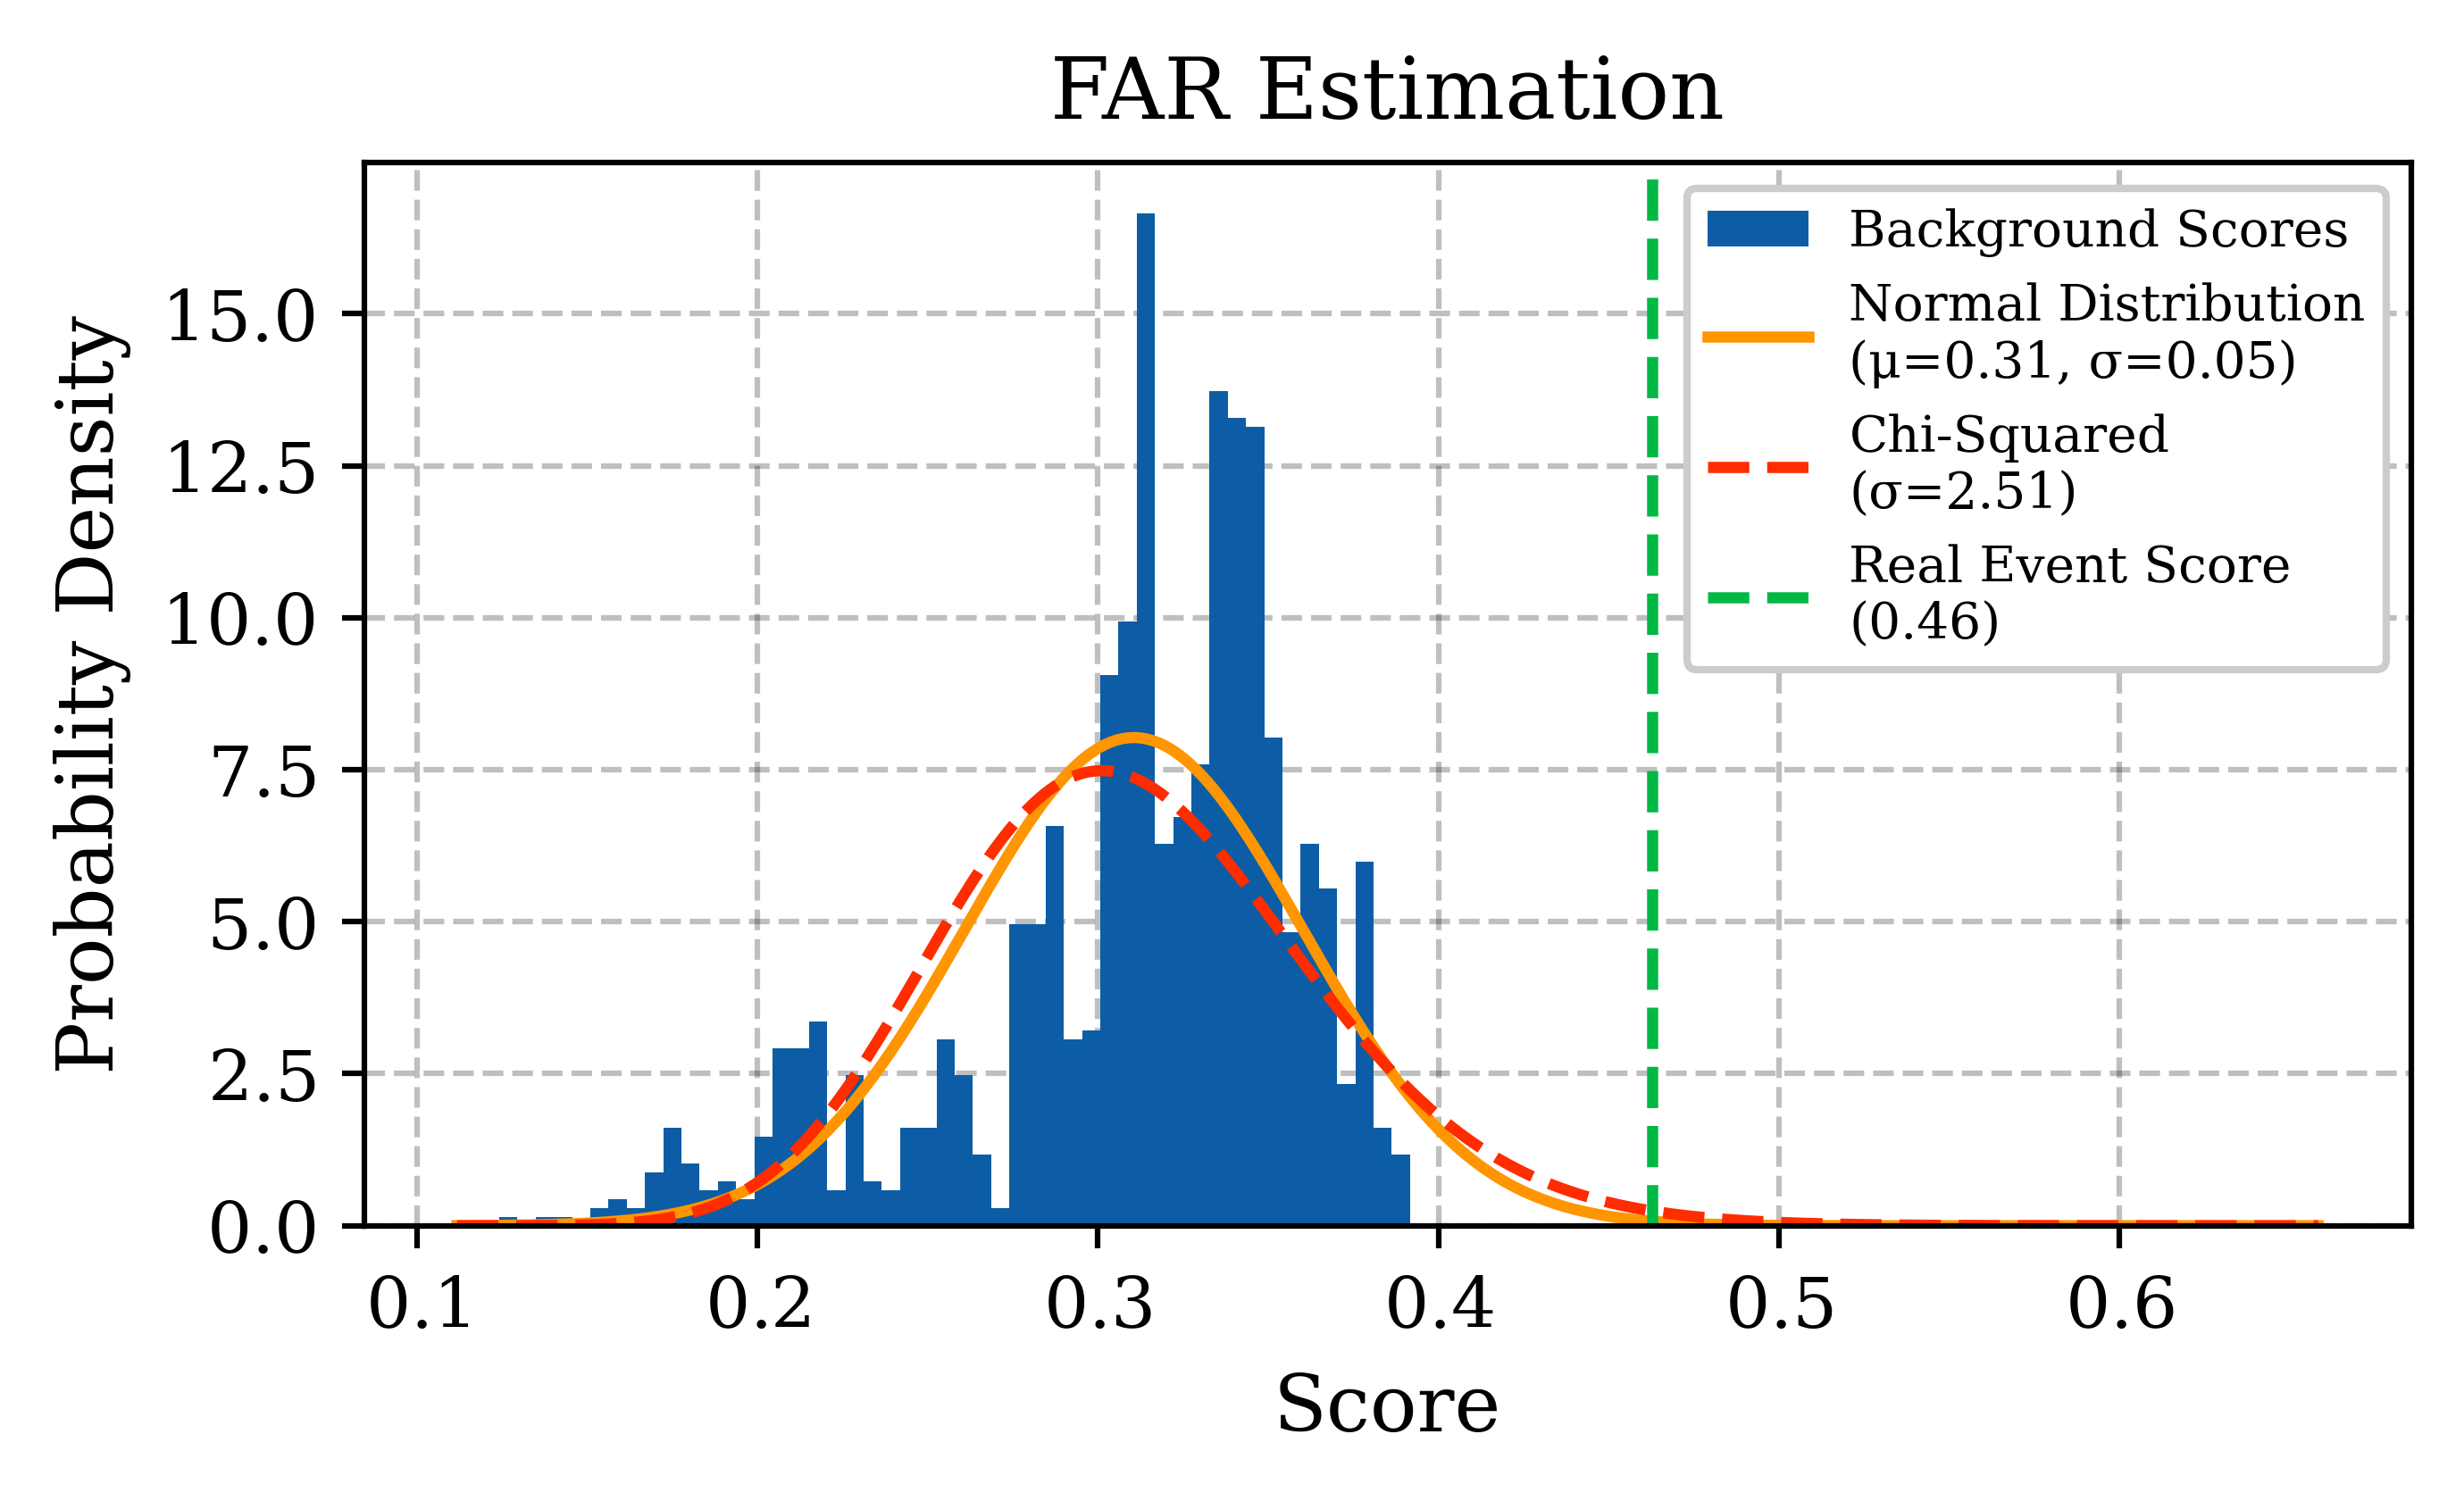

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ysy_plot_utils as ypu
import ysy_gw_data_utils as ygdu
import json
from scipy.stats import norm, chi2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

scores = np.loadtxt('scores.txt',              # 文件路径
                delimiter=None,          # 列分隔符；空格/制表符就留 None
                dtype=float,             # 数据类型
                skiprows=0,              # 跳过开头的行数（有表头就设 >0）
                usecols=None)            # 只读指定列

score = 0.4626603453981133

tot_N = 128*10
S_real = score
background_scores = np.array(scores)

from scipy.stats import norm

def evaluate_far_with_normal_fit(S_real, background_scores):
    """
    通过将正态分布拟合到背景得分，来评估假警报率(FAR)和统计显著性。

    参数:
    S_real (float): 真实候选事件的得分。
    background_scores (np.ndarray): 来自时域平移实验的一系列背景事件得分。

    返回:
    dict: 包含评估结果的字典。
    """
    if not isinstance(background_scores, np.ndarray):
        background_scores = np.array(background_scores)

    # 1. 将正态分布拟合到背景数据上
    # norm.fit() 会返回最佳拟合的均值(mu)和标准差(sigma)
    mu, sigma_dist = norm.fit(background_scores)

    # 2. 计算假警报概率 (False Alarm Probability, FAP)
    # FAP = P(背景得分 >= 真实得分)
    # 我们可以使用生存函数 (Survival Function, sf)，其定义就是 1 - CDF。
    fap_fitted = norm.sf(S_real, loc=mu, scale=sigma_dist)

    # 3. 计算统计显著性 (Significance in sigma)
    # 对于正态分布，这非常直观：就是计算真实得分偏离背景均值多少个标准差。
    # 这也被称为 Z-score。
    significance_sigma = (S_real - mu) / sigma_dist

    # --- 准备结果 ---
    results = {
        'mu': mu,
        'sigma_dist': sigma_dist,
        'fap_fitted': fap_fitted,
        'significance_sigma': significance_sigma
    }
    
    # --- 打印结果 ---
    print("\n正态分布拟合外推法")
    print(f"拟合的正态分布参数: μ (均值) = {mu:.2f}, σ (标准差) = {sigma_dist:.2f}")
    print(f"根据拟合分布，得分>={S_real:.2f}的概率(FAP)为: {fap_fitted:.2e}")
    print(f"对应的统计显著性为: {significance_sigma:.2f} σ (sigma)")
    
    return results

def evaluate_far_with_chi2_fit(S_real, background_scores):
    """
    通过将 Chi-squared 分布拟合到背景得分，来评估假警报率和统计显著性。
    """
    print("\n--- 使用 Chi-Squared 分布进行拟合与评估 ---")

    # 1. 将 Chi-squared 分布拟合到背景数据上
    # chi2.fit() 会返回最佳拟合的自由度(df)、位置(loc)和尺度(scale)
    # 我们固定loc=0，因为得分通常从0或一个正数开始
    df, loc, scale = chi2.fit(background_scores, floc=0)

    # 2. 计算假警报概率 (FAP)
    # FAP = P(背景得分 >= 真实得分)
    fap_fitted = chi2.sf(S_real, df, loc=loc, scale=scale)

    # 3. 从概率反算统计显著性 (sigma)
    significance_sigma = norm.ppf(1 - fap_fitted)

    # --- 打印结果 ---
    print(f"[Chi-Squared分布] FAP: {fap_fitted:.2e},  显著性: {significance_sigma:.2f} σ")
    print(f"  拟合参数: df(自由度)={df:.2f}, loc={loc:.2f}, scale={scale:.2f}")
    
    # 返回拟合参数用于可视化
    fit_params = {'df': df, 'loc': loc, 'scale': scale}
    return fit_params


# --- 示例：如何使用此函数 ---
if __name__ == '__main__':
    # --- 步骤二：调用函数进行评估 ---
    fit_results = evaluate_far_with_normal_fit(S_real, background_scores)
    chi2_fit_params = evaluate_far_with_chi2_fit(S_real, background_scores)

    # --- 步骤三：可视化结果 ---
    with ypu.temp_style(["ysy_academic", "science_color"]):
        plt.figure()
        plt.hist(background_scores, bins=50, density=True, alpha=1, label='Background Scores', color='C0')

        # 绘制拟合的正态分布曲线
        mu_fit = fit_results['mu']
        sigma_fit = fit_results['sigma_dist']
        x_axis = np.linspace(mu_fit - 4*sigma_fit, mu_fit + 7*sigma_fit, 400)
        y_axis = norm.pdf(x_axis, loc=mu_fit, scale=sigma_fit)
        plt.plot(x_axis, y_axis, color='C2', label=f'Normal Distribution\n(μ={mu_fit:.2f}, σ={sigma_fit:.2f})')
        df_c2, loc_c2, scale_c2 = chi2_fit_params.values()
        plt.plot(x_axis, chi2.pdf(x_axis, df_c2, loc=loc_c2, scale=scale_c2), 
            '--', color='C3', label=f'Chi-Squared\n(σ={norm.ppf(1-chi2.sf(S_real, **chi2_fit_params)):.2f})')

        # 标记真实事件的得分位置
        plt.axvline(S_real, color='C1', linestyle='--', label=f'Real Event Score\n({S_real:.2f})')

        plt.title('FAR Estimation')
        plt.xlabel('Score')
        plt.ylabel('Probability Density')
        plt.grid(True, alpha=0.25)
        plt.legend(fontsize=6.8)
        plt.tight_layout()
        plt.savefig('far_estimation.pdf')
        plt.show()

# 附录 B

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import ysy_plot_utils as ypu
from scipy.signal.windows import triang, tukey

import matplotlib.pyplot as plt

with ypu.temp_style(["ysy_academic", "science_color"]):
    plt.figure()
    for window, label in zip([np.ones(128), triang(128), tukey(128, alpha=0.25), np.hanning(128), np.blackman(128)],
                            ['rectangular', 'triangular', 'Tukey(r=0.25)', 'Hann','Blackman']
                            ):
        plt.plot(np.linspace(0,1,window.size), window, label=label)
    plt.ylabel("Amplitude")
    plt.xlabel("Sample")
    plt.legend()
    plt.ylabel('amplitude')
    plt.xlabel('time [t/T]')
    plt.yticks([0,0.2,0.4,0.6,0.8,1],['0','0.2','0.4','0.6','0.8','1'])
    plt.xticks([0,0.2,0.4,0.6,0.8,1],['0','0.2','0.4','0.6','0.8','1'])
    plt.xlim(0,1)
    plt.ylim(0,1.02)
    plt.show()

In [ ]:
with ypu.temp_style(["ysy_academic", "science_color"]):
    plt.figure()
    for window, label in zip([np.ones(128), triang(128), tukey(128, alpha=0.25), np.hanning(128), np.blackman(128)],
                            ['rectangular', 'triangular', 'Tukey(r=0.25)', 'Hann','Blackman'],
                            ):
        N = 1024
        A = np.fft.fft(window, N)/128*2
        y = np.abs(A)[:N//2] / np.abs(A)[0]
        index = (y ==0)
        y[index] = np.nan
        plt.plot(np.linspace(0,1,N//2),y, label=label, alpha=0.9)

    plt.yscale('log')
    plt.xscale('log')
    plt.xlim(1e-3,1e-0)
    plt.ylim(1e-10,1e-0)
    plt.legend()
    plt.ylabel('amplitude of leakage')
    plt.xlabel('offset from FFT bin center (in units of Nyquist freq)')
    plt.grid(which='both',axis='both', linestyle=':')
    plt.grid(which='major',axis='both', linestyle='--',c='k',alpha=0.6)
    plt.yticks([1e-0,1e-2,1e-4,1e-6,1e-8,1e-10])
    plt.xticks([1e-3,1e-2,1e-1,1e-0])
    plt.show()